In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vSReNRzjhxq3oT03rISUM7-5UcNf_flKxO0AjFGcPbx3HapArOSyucjKEszeNDWUX7Qymiwm1Bqt73A/pub?gid=53846645&single=true&output=csv')

In [ ]:
df.head()

,review,sentiment
0,But this movie was a bore. The history part wa...,0
1,Divorced lawyer Rick Magruder (Branagh) stumbl...,0
2,Man about the house is a true situation comedy...,1
3,"As a film buff, I obviously had read all the e...",1
4,That's about the only redeeming quality in a m...,0


In [ ]:
X = df['review']

In [ ]:
y = df['sentiment']

In [ ]:
message = X.copy()

In [ ]:
import spacy

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
corpus = []

import re

**Text Preprocessing**

In [ ]:
for review in message:
  review = re.sub(r'<[^>]+>', ' ', review) # removing HTML tags
  review = re.sub('[^a-zA-Z]', ' ' , review) # Only take alphanumaric text
  review = review.lower() # always lower case
  review = nlp(review) # spacy object
  review = [token.lemma_ for token in review if not token.is_stop] #TOkenization lemmatization and removing stop word
  review = ' '.join(review)
  corpus.append(review) # add to courpus


In [ ]:
voc_Size = 20000 # vocab size
max_len = 256 #maximum sequence length

**Text Vectorization**

In [ ]:
from keras.layers import TextVectorization

In [ ]:
vectorize_layer = TextVectorization(max_tokens=voc_Size, output_mode='int', output_sequence_length=max_len) #initate vectorizer with vocabulary size and sequence size
rep = vectorize_layer.adapt(corpus)
vectorized_corpus = vectorize_layer(corpus) # Text Vectorzation

In [ ]:
vectorized_corpus

<tf.Tensor: shape=(5000, 256), dtype=int64, numpy=
array([[   3,  864,  352, ...,    0,    0,    0],
       [2270, 2259, 1775, ...,    0,    0,    0],
       [  24,  158,  151, ...,    0,    0,    0],
       ...,
       [ 129, 1212,  637, ...,    0,    0,    0],
       [ 175,    4,   27, ...,    0,    0,    0],
       [ 248, 6494,    1, ...,    0,    0,    0]])>

In [ ]:
# Final 2-D array representaton
x_final = np.array(vectorized_corpus)
y_final = np.array(y)

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_final = label_encoder.fit_transform(y_final)

**Dataset Splitting**

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
x_final, y_final, test_size=0.20, random_state=42)

In [ ]:
import keras
from keras import ops
from keras import layers

**Initiate the Bi-LSTM Model**

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.layers import Embedding
from keras import Model
from keras import Input

from keras.regularizers import l2

inputs = keras.Input(shape=(None,), dtype="int64")  # Input layer for sequences of length 100
x = Embedding(voc_Size, 64)(inputs)
print("After embadding ", x.shape)


x = Bidirectional(LSTM(32, return_sequences=True))(x)
x = Bidirectional(LSTM(32, dropout=0.5, kernel_regularizer=l2(0.001)))(x) #lstm layer with dropout and L2 optimization

outputs = layers.Dense(1, activation="sigmoid")(x)
bilstmModel = Model(inputs=inputs, outputs=outputs)
bilstmModel.summary()


After embadding  (None, None, 64)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, None, 64)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, None, 64)       │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,329,729 (5.07 MB)

 Trainable params: 1,329,729 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

**Run Bilstm Model on Dataset**

In [ ]:
bilstmModel.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
bilstmModel.fit(X_train, y_train, batch_size=128, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9994 - loss: 0.0098 - val_accuracy: 0.8050 - val_loss: 1.0523
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9961 - loss: 0.0238 - val_accuracy: 0.8130 - val_loss: 0.8588
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9975 - loss: 0.0205 - val_accuracy: 0.8100 - val_loss: 0.8914
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9967 - loss: 0.0161 - val_accuracy: 0.8140 - val_loss: 0.7564
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9962 - loss: 0.0196 - val_accuracy: 0.7900 - val_loss: 0.7718
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9977 - loss: 0.0182 - val_accuracy: 0.8120 - val_loss: 0.8707
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9973 - loss: 0.0160 - val_accuracy: 0.8140 - val_loss: 0.8616
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9983 - loss: 0.0123 - val_accuracy: 0.8030 - v

**Prediction of BILSTM**

In [ ]:
bilstm_pred_probs = bilstmModel.predict(X_test)
bilstm_pred = (bilstm_pred_probs > 0.5)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


**Confusion Matrix of Bilstm**

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score

# Compute confusion matrix
bilstm_conf_matrix = confusion_matrix(y_test, bilstm_pred)

print("Bi-LSTM Confusion Matrix:")
print(bilstm_conf_matrix)

Bi-LSTM Confusion Matrix:
[[409  86]
 [ 98 407]]


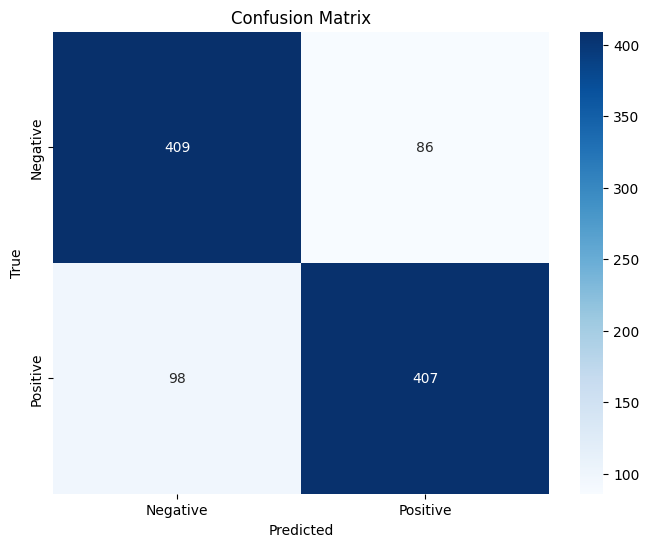

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(bilstm_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

**Accuracy, Recall, F1-Score of BiLSTM**

In [ ]:
bilstm_accuracy = accuracy_score(y_test, bilstm_pred)
bilstm_recall = recall_score(y_test, bilstm_pred)
bilstm_f1 = f1_score(y_test, bilstm_pred)

print("Bi-LSTM Accuracy:", bilstm_accuracy)
print("Bi-LSTM Recall:", bilstm_recall)
print("Bi-LSTM F1 Score:", bilstm_f1)

Bi-LSTM Accuracy: 0.816
Bi-LSTM Recall: 0.805940594059406
Bi-LSTM F1 Score: 0.8156312625250501


**Initiating Transformer block**

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.5):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

**Token Position Embadding**

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

**Creating Transformer Model**

In [ ]:
embed_dim =32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32 # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(256,))
embedding_layer = TokenAndPositionEmbedding(1024, voc_Size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.5)(x) #drop Out layer
x = layers.Dense(20, activation="relu", kernel_regularizer=l2(0.001))(x) # Dense Layer with L2 optimization
x = layers.Dropout(0.5)(x) #drop Out layer
outputs = layers.Dense(1, activation="sigmoid")(x)

transformerModel = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
transformerModel.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_3  │ (None, 256, 32)        │       672,768 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_3             │ (None, 256, 32)        │        10,656 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 20)             │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,105 (2.61 MB)

 Trainable params: 684,105 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

**Train Dataset on Transformer Model**

In [ ]:
transformerModel.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = transformerModel.fit(
    X_train, y_train, batch_size=128, epochs=50, validation_data=(X_test, y_test)
)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 285ms/step - accuracy: 0.5112 - loss: 0.7559 - val_accuracy: 0.4950 - val_loss: 0.7181
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.5082 - loss: 0.7253 - val_accuracy: 0.5040 - val_loss: 0.7126
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5157 - loss: 0.7178 - val_accuracy: 0.5540 - val_loss: 0.7065
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5285 - loss: 0.7133 - val_accuracy: 0.5070 - val_loss: 0.7080
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5686 - loss: 0.6989 - val_accuracy: 0.7710 - val_loss: 0.6850
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6321 - loss: 0.6686 - val_accuracy: 0.6700 - val_loss: 0.6123
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6835 - loss: 0.6051 - val_accuracy: 0.7750 - val_loss: 0.4889
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8473 - loss: 0.4107 - val_accuracy: 0.8450 -

**Transformer Model Prediction**

In [ ]:
transformer_pred_probs = transformerModel.predict(X_test)
transformer_pred = (transformer_pred_probs > 0.5)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


**Confusion Matric for Transformer**

In [ ]:


# Compute confusion matrix
transformer_conf_matrix = confusion_matrix(y_test, transformer_pred)

print("transformer Confusion Matrix:")
print(transformer_conf_matrix)

transformer Confusion Matrix:
[[438  57]
 [ 72 433]]


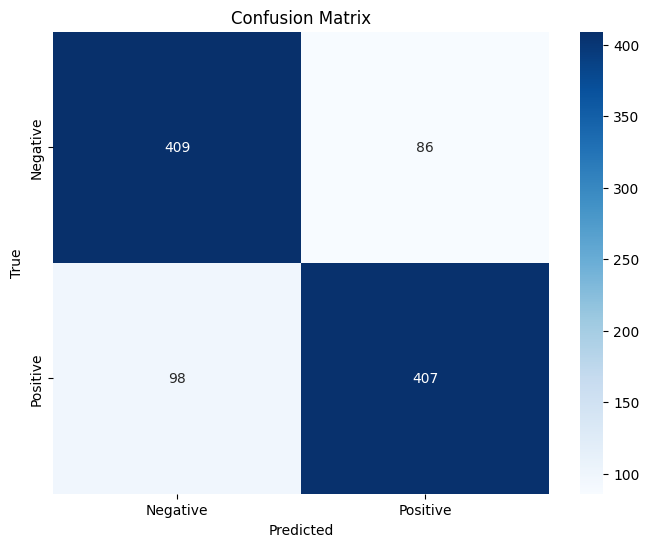

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(bilstm_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

**Accuracy, Recall, F1-score of Transformer**

In [ ]:
transformer_accuracy = accuracy_score(y_test, transformer_pred)
transformer_recall = recall_score(y_test, transformer_pred)
transformer_f1 = f1_score(y_test, transformer_pred)

print("transformer Accuracy:", transformer_accuracy)
print("transformer Recall:", transformer_recall)
print("transformer F1 Score:", transformer_f1)

transformer Accuracy: 0.871
transformer Recall: 0.8574257425742574
transformer F1 Score: 0.8703517587939699


**Testing a instance**

In [ ]:
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    x_final, y_final, df.index, test_size=0.20, random_state=42
)

In [ ]:
test_idx = idx_test[0]  # this is the integer index of the row in df

# Original review and label
original_text = df.loc[test_idx, 'review']
original_label = df.loc[test_idx, 'sentiment']
print("Original review:", original_text)
print("Original label:", original_label)

# Preprocessed text
processed_text = corpus[test_idx]
print("Processed text:", processed_text)
bilstm_prediction = bilstmModel.predict(X_test[0].reshape(1, -1))
transformer_prediction = transformerModel.predict(X_test[0].reshape(1, -1))

print("Bi-LSTM Prediction:", bilstm_prediction)
print("Transformer Prediction:", transformer_prediction)

Original review: And here's yet another piece of evidence to claim that we should all worship the Italian giallo and acknowledge it to be the absolute most unique sub genre in horror. Emilio Miraglia's "The Red Queen Kills Seven Times" is a totally mesmerizing wholesome of original plotting, stylish production values, enchanting music, great acting talents and inventively gory murder sequences. It's a fabulous giallo (released in the golden year 1972) that belongs in the top-five of every fan of Italian cinema. The storyline doesn't just introduce your average black-gloved & sexually frustrated killer, but blends good old-fashioned revenge motives with the macabre myth of the murderous "Red Queen". At young age, their grandfather tells the constantly fighting siblings Kitty and Evelyn about an uncanny lady who, once every 100 years on April 6th, kills seven people of which her sister is the inevitable last victim. Fourteen years later, Kitty has become the successful choreographer of a

**Save The Models**

In [ ]:
bilstmModel.save('bilstmModel.h5')
transformerModel.save('transformerModel.h5')